# Portafolios de Inversión
## Last Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [103]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [104]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [105]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [106]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

#### Función de Backtesting

In [107]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Desempeño 

In [108]:
def metrics(history , rf):
    # Returns
    rets = history.pct_change().dropna()
    # Cov
    cov = rets.cov()
    # DataFrame
    df = pd.DataFrame(index=rets.columns)
    # Rendimientos
    df['Rendimiento Anualizado'] =r_p=  rets.mean() * 252*100
    # Volatilidad
    df['Volatilidad Anualizada'] =vol=  rets.std() * np.sqrt(252)*100
    # Sharpe
    df['Sharpe'] = (r_p - rf/252)/vol

    # Downside Risk
    df['Downside Risk'] = Downside = rets[rets < 0].std()*np.sqrt(252)
    
    # Upside Risk
    df['Upside Risk'] = upside = rets[rets > 0].std()*np.sqrt(252)
    # Omega
    df['Omega'] = omega = upside / Downside
    # Beta
    cov_b = cov['Benchmark']
    var_b = cov_b['Benchmark']
    df['Beta']=beta = cov_b / var_b
    # Alpha
    r_m = rets['Benchmark'].mean() * 252
    df['Alpha'] = alpha = r_p - (rf/252 + beta * (r_m - rf/252))

    # Sortino (downside)
    df['Sortino'] = (r_p - rf/252)/Downside
    # Taylor (beta)
    df['Taylor'] = (r_p - rf/252) / beta

    return df.T


#### Importación de Datos

In [109]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

In [110]:
opt_prices = yf.download(tickers, start='2023-01-01', end='2024-01-01', progress=False)['Close']
bt_prices = yf.download(tickers, start='2024-01-01', progress=False)['Close']
benchmark = yf.download('^GSPC', start='2024-01-01', progress=False)['Close']


In [111]:
rets= opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
corr = rets.corr()
rets_bt = bt_prices.pct_change().dropna()

##### Función Mínima Varianza 

In [112]:
w_minvar = opt_min_var(rets)
w_minvar

array([7.12389762e-01, 2.52033844e-02, 3.56305621e-02, 2.26776291e-01,
       8.45815337e-18])

##### Función Máximo de Sharpe

In [113]:
w_maxsharpe = opt_max_sharpe(rets, rf=0.045)
w_maxsharpe

array([4.97086714e-01, 1.74160148e-01, 3.02198691e-18, 1.84644953e-01,
       1.44108185e-01])

##### Función Semi-Varianza Target

In [114]:
w_semivar = objetivo(rets, rets_b, corr)
w_semivar

{'AAPL': 0.2, 'AMZN': 0.2, 'GOOGL': 0.2, 'MSFT': 0.2, 'TSLA': 0.2}

#### Función de Backtesting

In [115]:
capital = 1000000

In [116]:
w_dict = {
    'Min Var': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semivariance': w_semivar,
    'Benchmark': 1
}

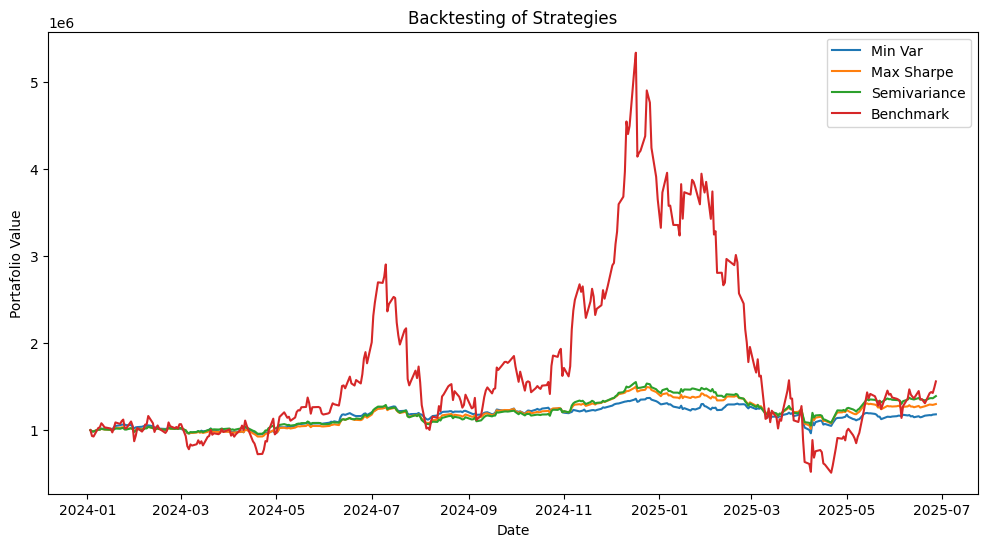

In [117]:
history = backtesting(bt_prices , benchmark, w_dict, capital)

##### Función Desempeño 

In [118]:
metrics = metrics(history, rf=0.045)
metrics

,Min Var,Max Sharpe,Semivariance,Benchmark
Rendimiento Anualizado,14.617577,21.689685,26.566215,132.831077
Volatilidad Anualizada,25.705870,27.990853,28.923699,144.618496
Sharpe,0.568640,0.774878,0.918487,0.918492
Downside Risk,0.185235,0.196038,0.193894,0.969471
Upside Risk,0.197805,0.209562,0.210357,1.051785
Omega,1.067858,1.068987,1.084906,1.084906
Beta,0.145723,0.185095,0.200000,1.000000
Alpha,14.423858,21.443676,26.300410,131.502767
Sortino,78.912676,110.639579,137.013069,137.013806
Taylor,100.309216,117.180218,132.830184,132.830899


### Portafolio Real

In [128]:
# Portafolio Real
re_opt = pd.DataFrame(index= rets.keys())
re_opt['w']= opt_max_sharpe(rets_bt, 0.045)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt


,w,Cash,Acciones
Ticker,,,
AAPL,0.000000e+00,0.000000e+00,0.0
AMZN,5.271179e-01,5.271179e+05,2360.0
GOOGL,1.114447e-17,1.114447e-11,0.0
MSFT,4.206698e-01,4.206698e+05,848.0
TSLA,5.221230e-02,5.221230e+04,161.0
